# Convolutional Neural Networks: Step by Step

We will implement convolutional (CONV) and pooling (POOL) layers in numpy, including both forward propagation and backward propagation. 

**Notation**:
- Superscript $[l]$ denotes an object of the $l^{th}$ layer. 
    - Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.


- Superscript $(i)$ denotes an object from the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example input.
    
    
- Subscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$, assuming this is a fully connected (FC) layer.
    
    
- $n_H$, $n_W$ and $n_C$ denote respectively the height, width and number of channels of a given layer. If you want to reference a specific layer $l$, you can also write $n_H^{[l]}$, $n_W^{[l]}$, $n_C^{[l]}$. 
- $n_{H_{prev}}$, $n_{W_{prev}}$ and $n_{C_{prev}}$ denote respectively the height, width and number of channels of the previous layer. If referencing a specific layer $l$, this could also be denoted $n_H^{[l-1]}$, $n_W^{[l-1]}$, $n_C^{[l-1]}$. 

## 1 - Packages

Let's first import all the packages that we will need. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent.

In [3]:
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Outline

We will be implementing the building blocks of a convolutional neural network! Each functionweyou will implement will have detailed instructions that will walk you through the steps needed:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward

<img src="images/model.png" style="width:800px;height:300px;">

**Note** that for every forward function, there is its corresponding backward equivalent. Hence, at every step of our forward module we will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

## 3 - Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

<img src="images/conv_nn.png" style="width:350px;height:200px;">

In this part, we will build every step of the convolution layer. 
We will first implement two helper functions: one for zero padding and the other for computing the convolution function itself. 

### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are the following:

- It allows us to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as we go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

We are Implementing the following function, which pads all the images of a batch of examples X with zeros. [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if we want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, you would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [4]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    x_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values = (0, 0))
    
    return x_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


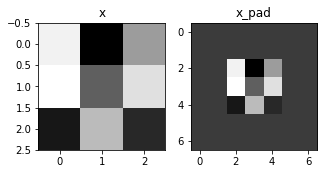

In [5]:
np.random.seed(1)

x = np.random.randn(4, 3, 3, 2) # no_of_examples, heights, widths, no_of_channels
x_pad = zero_pad(x, 2)

print (f"x.shape = {x.shape}")
print (f"x_pad.shape = {x_pad.shape}")
print (f"x[1,1] = {x[1,1]}")
print (f"x_pad[1,1] = {x_pad[1,1]}")

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

**Expected Output**:

```
x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
```